In [ ]:
from node2vec import *
from gensim.models import KeyedVectors
import numpy as np
import os 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
os.environ['PYTHONHASHSEED']='123'
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, f1_score, plot_roc_curve, auc, accuracy_score, roc_auc_score, roc_curve, matthews_corrcoef
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [ ]:
#run node2vec with p and q, and h parameters respectively
def run_walks(graph, p, q):
    graph = read_graph(graph, weighted = True)
    random.seed(1)
    np.random.seed(1)
    G = Node2Vec(graph, p, q)
    G.preprocess_transition_probs()
    walks = G.simulate_walks(num_walks = 20, walk_length = 80)
    return walks

def run_walks_hub(graph, h):
    graph = read_graph(graph, weighted = True)
    random.seed(1)
    np.random.seed(1)
    G = HubsWalker(graph, h)
    G.preprocess_transition_probs()
    walks = G.simulate_walks(num_walks = 20, walk_length = 80)
    return walks

def embeddings(walks, dimensions, output):
    model = learn_embeddings(walks, dimensions, 10, 5, output)
    return model

In [ ]:
#random walk parametrization trials, for PPI EXP subnetwork with different edge scores
model_p25_q200_IC = embeddings(run_walks('PPI_EXP_scaled_IC.txt', p = 0.25, q = 2), 512, 'model_p25_q200_IC.txt')
model_p25_q200_agg = embeddings(run_walks('PPI_EXP_aggregated_scores.txt', p = 0.25, q = 2), 512, 'model_p25_q200_agg.txt')
model_p25_q200_fsim = embeddings(run_walks('FSim_PPI_EXP.txt', p = 0.25, q = 2), 512, 'model_p25_q200_fsim.txt')

Walk 20/20: 100%|██████████| 2968/2968 [00:19<00:00, 154.03it/s]


In [ ]:
model_p50_q100_IC = embeddings(run_walks('PPI_EXP_scaled_IC.txt', p = 0.5, q = 1), 512, 'model_p50_q100_IC.txt')
model_p50_q100_agg = embeddings(run_walks('PPI_EXP_aggregated_scores.txt', p = 0.5, q = 1), 512, 'model_p50_q100_agg.txt')
model_p50_q100_fsim = embeddings(run_walks('FSim_PPI_EXP.txt', p = 0.5, q = 1), 512, 'model_p50_q100_fsim.txt')

Walk 20/20: 100%|██████████| 2968/2968 [00:18<00:00, 161.16it/s]


In [ ]:
model_p200_q25_IC = embeddings(run_walks('PPI_EXP_scaled_IC.txt', p = 2, q = 0.25), 512, 'model_p200_q25_IC.txt')
model_p200_q25_agg = embeddings(run_walks('PPI_EXP_aggregated_scores.txt', p = 2, q = 0.25), 512, 'model_p200_q25_agg.txt')
model_p200_q25_fsim = embeddings(run_walks('FSim_PPI_EXP.txt', p = 2, q = 0.25), 512, 'model_p200_q25_fsim.txt')

Walk 20/20: 100%|██████████| 2968/2968 [00:18<00:00, 160.30it/s]


In [ ]:
model_h50_IC = embeddings(run_walks_hub('PPI_EXP_scaled_IC.txt', h = 0.5), 512, 'model_h50_IC.txt')
model_h50_agg = embeddings(run_walks_hub('PPI_EXP_aggregated_scores.txt', h = 0.5), 512, 'model_h50_agg.txt')
model_h50_fsim = embeddings(run_walks_hub('FSim_PPI_EXP.txt', h = 0.5), 512, 'model_h50_fsim.txt')

Walk 20/20: 100%|██████████| 2968/2968 [00:23<00:00, 125.13it/s]


In [ ]:
model_h75_IC = embeddings(run_walks_hub('PPI_EXP_scaled_IC.txt', h = 0.75), 512, 'model_h75_IC.txt')
model_h75_agg = embeddings(run_walks_hub('PPI_EXP_aggregated_scores.txt', h = 0.75), 512, 'model_h75_agg.txt')
model_h75_fsim = embeddings(run_walks_hub('FSim_PPI_EXP.txt', h = 0.75), 512, 'model_h75_fsim.txt')

Walk 20/20: 100%|██████████| 2968/2968 [00:20<00:00, 144.48it/s]


In [ ]:
model_h400_IC = embeddings(run_walks_hub('PPI_EXP_scaled_IC.txt', h = 4), 512, 'model_h400_IC.txt')
model_h400_agg = embeddings(run_walks_hub('PPI_EXP_aggregated_scores.txt', h = 4), 512, 'model_h400_agg.txt')
model_h400_fsim = embeddings(run_walks_hub('FSim_PPI_EXP.txt', h = 4), 512, 'model_h400_fsim.txt')

Walk 20/20: 100%|██████████| 2968/2968 [00:13<00:00, 226.51it/s]


In [ ]:
model_h800_IC = embeddings(run_walks_hub('PPI_EXP_scaled_IC.txt', h = 8), 512, 'model_h800_IC.txt')
model_h800_agg = embeddings(run_walks_hub('PPI_EXP_aggregated_scores.txt', h = 8), 512, 'model_h800_agg.txt')
model_h800_fsim = embeddings(run_walks_hub('FSim_PPI_EXP.txt', h = 8), 512, 'model_h800_fsim.txt')

Walk 20/20: 100%|██████████| 2968/2968 [00:12<00:00, 242.82it/s]


In [ ]:
#function for loading the embeddings of ageing gene products, label encoding
def load_genage_embeddings(embedding_file, genage_data):
    model = pd.read_csv(embedding_file, sep = ' ', header = None, skiprows = 1)
    model = model.rename(columns={0: 'STRING ID'})
    model_df = pd.merge(model, genage_data, on = ['STRING ID'])
    X = model_df.values[:, 1:(model_df.shape[1]-1)]
    y = LabelEncoder().fit_transform(model_df.values[:, model_df.shape[1]-1])
    return [X, y]

In [ ]:
genage_data = pd.read_csv('genage_full.txt', sep = '\t')  
genage_data = genage_data[['STRING ID', 'Longevity Influence']]

In [ ]:
#fit GridSearchCV tuned SVM models, return best validation results 
def svc_crossvalidation(model_df):
    classifier = SVC()
    MCC = make_scorer(matthews_corrcoef)
    param_grid = [
    {'C': [1, 10, 0.1, 100, 0.01, 1000, 0.001], 'kernel': ['linear']},
    {'C': [1, 10, 0.1, 100, 0.01, 1000, 0.001],
      'gamma': [1.0, 0.5, 3, 0.2, 10, 0.1, 0.03, 0.01, 0.001], 'kernel': ['rbf']}]
    clf1 = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring = 'f1', cv=5)
    clf2 = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring = 'accuracy', cv=5)
    clf3 = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring = 'roc_auc', cv=5)
    clf4 = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring = MCC, cv=5)
    clf1.fit(model_df[0], model_df[1])
    clf2.fit(model_df[0], model_df[1])
    clf3.fit(model_df[0], model_df[1])
    clf4.fit(model_df[0], model_df[1])
    results = {'F1 params': clf1.best_params_, 
              'Accuracy params': clf2.best_params_, 
              'AUC params': clf3.best_params_, 
              'MCC params': clf4.best_params_, 
               'F1': clf1.best_score_,
               'Accuracy': clf2.best_score_,
               'AUC': clf3.best_score_,
               'MCC': clf4.best_score_}
    return results

In [ ]:
IC_p200_q25 = svc_crossvalidation(load_genage_embeddings('model_p200_q25_IC.txt', genage_data))
Agg_p200_q25 = svc_crossvalidation(load_genage_embeddings('model_p200_q25_agg.txt', genage_data))
fsim_p200_q25 = svc_crossvalidation(load_genage_embeddings('model_p200_q25_fsim.txt', genage_data))

IC_p50_q100 = svc_crossvalidation(load_genage_embeddings('model_p50_q100_IC.txt', genage_data))
Agg_p50_q100 = svc_crossvalidation(load_genage_embeddings('model_p50_q100_agg.txt', genage_data))
fsim_p50_q100 = svc_crossvalidation(load_genage_embeddings('model_p50_q100_fsim.txt', genage_data))

IC_p25_q200 = svc_crossvalidation(load_genage_embeddings('model_p25_q200_IC.txt', genage_data))
Agg_p25_q200 = svc_crossvalidation(load_genage_embeddings('model_p25_q200_agg.txt', genage_data))
fsim_p25_q200 = svc_crossvalidation(load_genage_embeddings('model_p25_q200_fsim.txt', genage_data))

IC_p1_q1 = svc_crossvalidation(load_genage_embeddings('IC 512.txt', genage_data))
Agg_p1_q1 = svc_crossvalidation(load_genage_embeddings('Aggregated 512.txt', genage_data))
fsim_p1_q1 = svc_crossvalidation(load_genage_embeddings('fsim 512.txt', genage_data))

In [ ]:
#SVM validation results, classification performance for p and q parametrization
scores = ['F1', 'Accuracy', 'AUC', 'MCC']
svc_metrics = pd.DataFrame([[IC_p200_q25[score] for score in scores],
                            [Agg_p200_q25[score] for score in scores],
                            [fsim_p200_q25[score] for score in scores],
                            [IC_p50_q100[score] for score in scores],
                            [Agg_p50_q100[score] for score in scores],
                            [fsim_p50_q100[score] for score in scores],
                            [IC_p25_q200[score] for score in scores],
                            [Agg_p25_q200[score] for score in scores],
                            [fsim_p25_q200[score] for score in scores],
                            [IC_p1_q1[score] for score in scores],
                            [Agg_p1_q1[score] for score in scores],
                            [fsim_p1_q1[score] for score in scores]], columns = scores)
svc_metrics.head(20)

,F1,Accuracy,AUC,MCC
0,0.494058,0.623643,0.665023,0.183630
1,0.467353,0.641592,0.705306,0.197960
2,0.431201,0.621046,0.636206,0.137680
3,0.513631,0.672527,0.734690,0.290592
4,0.475895,0.636697,0.654102,0.201546
5,0.530790,0.667399,0.712894,0.288604
6,0.528235,0.654579,0.706843,0.243962
7,0.525261,0.657309,0.687938,0.253039
8,0.449931,0.621012,0.671726,0.176104
9,0.607053,0.711289,0.751326,0.390298


In [ ]:
IC_h50 = svc_crossvalidation(load_genage_embeddings('model_h50_IC.txt', genage_data))
Agg_h50 = svc_crossvalidation(load_genage_embeddings('model_h50_agg.txt', genage_data))
fsim_h50 = svc_crossvalidation(load_genage_embeddings('model_h50_fsim.txt', genage_data))

IC_h75 = svc_crossvalidation(load_genage_embeddings('model_h75_IC.txt', genage_data))
Agg_h75 = svc_crossvalidation(load_genage_embeddings('model_h75_agg.txt', genage_data))
fsim_h75 = svc_crossvalidation(load_genage_embeddings('model_h75_fsim.txt', genage_data))

IC_h400 = svc_crossvalidation(load_genage_embeddings('model_h400_IC.txt', genage_data))
Agg_h400 = svc_crossvalidation(load_genage_embeddings('model_h400_agg.txt', genage_data))
fsim_h400 = svc_crossvalidation(load_genage_embeddings('model_h400_fsim.txt', genage_data))

IC_h800 = svc_crossvalidation(load_genage_embeddings('model_h800_IC.txt', genage_data))
Agg_h800 = svc_crossvalidation(load_genage_embeddings('model_h800_agg.txt', genage_data))
fsim_h800 = svc_crossvalidation(load_genage_embeddings('model_h800_fsim.txt', genage_data))

In [ ]:
#SVM validation results, classification performance for h parametrization
scores = ['F1', 'Accuracy', 'AUC', 'MCC']
svc_metrics_hubs = pd.DataFrame([[IC_h50[score] for score in scores],
                            [Agg_h50[score] for score in scores],
                            [fsim_h50[score] for score in scores],
                            [IC_h75[score] for score in scores],
                            [Agg_h75[score] for score in scores],
                            [fsim_h75[score] for score in scores],
                            [IC_h400[score] for score in scores],
                            [Agg_h400[score] for score in scores],
                            [fsim_h400[score] for score in scores],
                            [IC_h800[score] for score in scores],
                            [Agg_h800[score] for score in scores],
                            [fsim_h800[score] for score in scores]], columns = scores)
svc_metrics_hubs.head(20)

,F1,Accuracy,AUC,MCC
0,0.467664,0.631269,0.652998,0.190131
1,0.556329,0.662304,0.697073,0.283153
2,0.492688,0.631602,0.685843,0.210807
3,0.532357,0.662271,0.729489,0.259400
4,0.475714,0.649617,0.686067,0.235755
5,0.528775,0.667599,0.708296,0.274479
6,0.585233,0.690809,0.751926,0.346030
7,0.459143,0.639128,0.696124,0.211174
8,0.495664,0.649451,0.703405,0.236053
9,0.490507,0.634066,0.695297,0.208148


In [ ]:
#plotting ROC curves for p and q parametrization
def plot_auc(data, genage_data, parameters):
    model_df = load_genage_embeddings(data, genage_data)
    X = model_df[0]
    y = model_df[1]
    kf = StratifiedKFold(n_splits = 5)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i, (train, test) in enumerate(kf.split(X, y)):
        if parameters['AUC params']['kernel'] == 'linear':
            svc = SVC(kernel = parameters['AUC params']['kernel'], C = parameters['AUC params']['C'], probability = True)
        elif parameters['AUC params']['kernel'] == 'rbf':
            svc = SVC(kernel = parameters['AUC params']['kernel'], C = parameters['AUC params']['C'], gamma = parameters['AUC params']['gamma'], probability = True)
        model = svc.fit(X[train], y[train])
        y_score = model.predict_proba(X[test])
        fpr, tpr, _ = roc_curve(y[test], y_score[:, 1])
        tpr = np.interp(mean_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
    
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    return mean_tprs

In [ ]:
p200_q25_IC_auc = plot_auc('model_p200_q25_IC.txt', genage_data, IC_p200_q25)
p200_q25_agg_auc = plot_auc('model_p200_q25_agg.txt', genage_data, Agg_p200_q25)
p200_q25_fsim_auc = plot_auc('model_p200_q25_fsim.txt', genage_data, fsim_p200_q25)

p50_q100_IC_auc = plot_auc('model_p50_q100_IC.txt', genage_data, IC_p50_q100)
p50_q100_agg_auc = plot_auc('model_p50_q100_agg.txt', genage_data, Agg_p50_q100)
p50_q100_fsim_auc = plot_auc('model_p50_q100_fsim.txt', genage_data, fsim_p50_q100)

p25_q200_IC_auc = plot_auc('model_p25_q200_IC.txt', genage_data, IC_p25_q200)
p25_q200_agg_auc = plot_auc('model_p25_q200_agg.txt', genage_data, Agg_p25_q200)
p25_q200_fsim_auc = plot_auc('model_p25_q200_fsim.txt', genage_data, fsim_p25_q200)

p1_q1_IC_auc = plot_auc('IC 512.txt', genage_data, IC_p1_q1)
p1_q1_agg_auc = plot_auc('Aggregated 512.txt', genage_data, Agg_p1_q1)
p1_q1_fsim_auc = plot_auc('fsim 512.txt', genage_data, fsim_p1_q1)

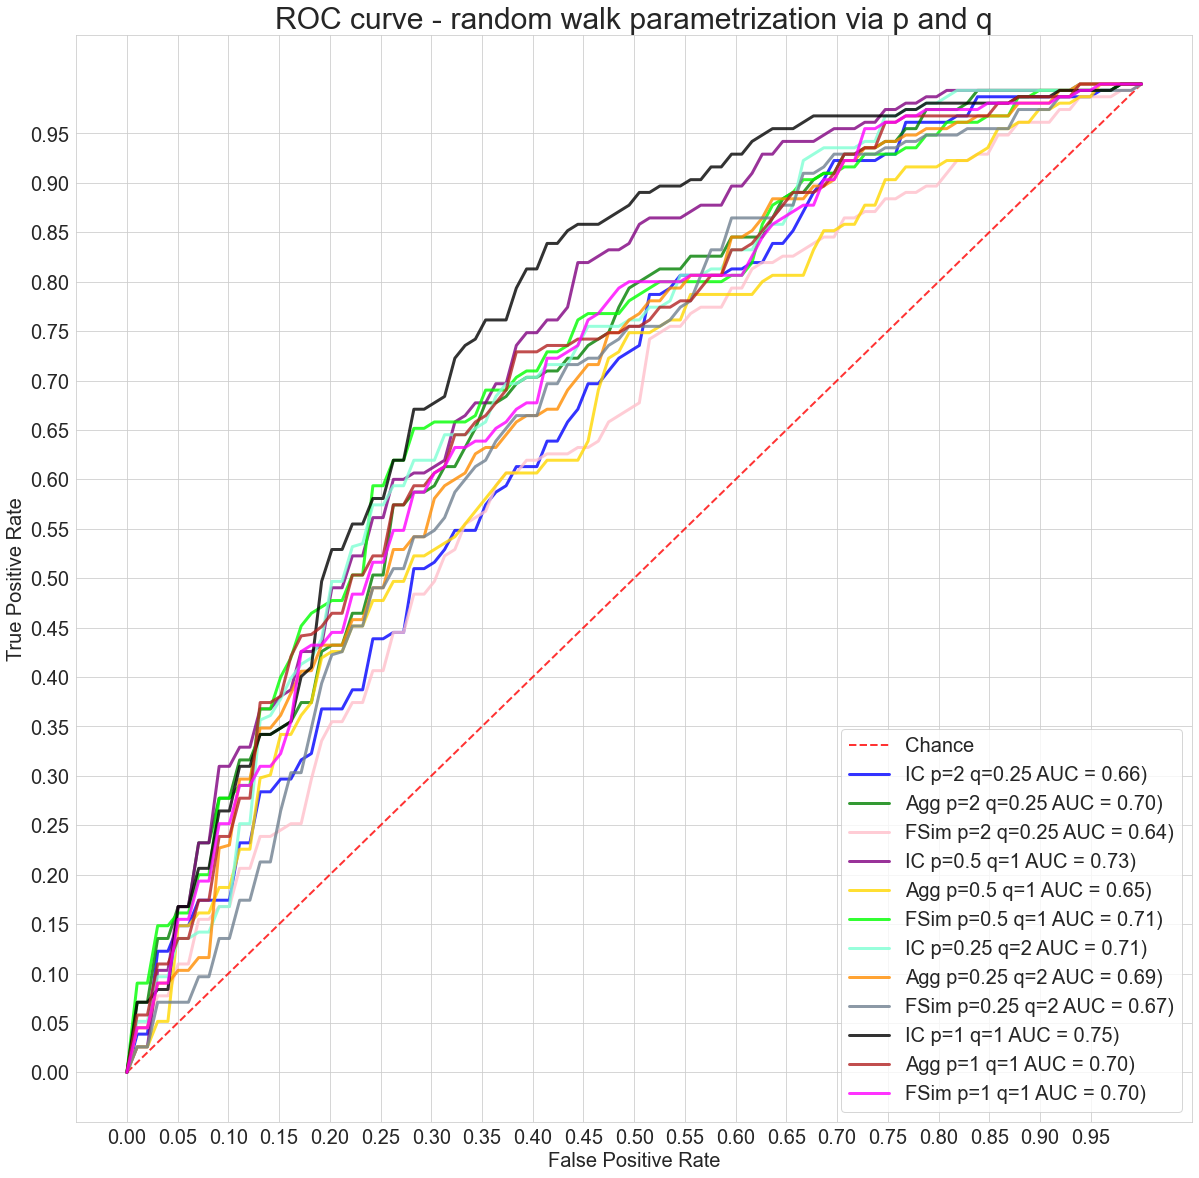

In [ ]:
import seaborn as sns
mean_fpr = np.linspace(0, 1, 100)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(20, 20))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

ax.plot(mean_fpr, p200_q25_IC_auc, color='b', label=r'IC p=2 q=0.25 AUC = %0.2f)' % (auc(mean_fpr, p200_q25_IC_auc)), lw=3, alpha=.8)
ax.plot(mean_fpr, p200_q25_agg_auc, color='g', label=r'Agg p=2 q=0.25 AUC = %0.2f)' % (auc(mean_fpr, p200_q25_agg_auc)), lw=3, alpha=.8)
ax.plot(mean_fpr, p200_q25_fsim_auc, color='pink', label=r'FSim p=2 q=0.25 AUC = %0.2f)' % (auc(mean_fpr, p200_q25_fsim_auc)), lw=3, alpha=.8)

ax.plot(mean_fpr, p50_q100_IC_auc, color='purple', label=r'IC p=0.5 q=1 AUC = %0.2f)' % (auc(mean_fpr, p50_q100_IC_auc)), lw=3, alpha=.8)
ax.plot(mean_fpr, p50_q100_agg_auc, color='gold', label=r'Agg p=0.5 q=1 AUC = %0.2f)' % (auc(mean_fpr, p50_q100_agg_auc)), lw=3, alpha=.8)
ax.plot(mean_fpr, p50_q100_fsim_auc, color='lime', label=r'FSim p=0.5 q=1 AUC = %0.2f)' % (auc(mean_fpr, p50_q100_fsim_auc)), lw=3, alpha=.8)

ax.plot(mean_fpr, p25_q200_IC_auc, color='aquamarine', label=r'IC p=0.25 q=2 AUC = %0.2f)' % (auc(mean_fpr, p25_q200_IC_auc)), lw=3, alpha=.8)
ax.plot(mean_fpr, p25_q200_agg_auc, color='darkorange', label=r'Agg p=0.25 q=2 AUC = %0.2f)' % (auc(mean_fpr, p25_q200_agg_auc)), lw=3, alpha=.8)
ax.plot(mean_fpr, p25_q200_fsim_auc, color='slategrey', label=r'FSim p=0.25 q=2 AUC = %0.2f)' % (auc(mean_fpr, p25_q200_fsim_auc)), lw=3, alpha=.8)

ax.plot(mean_fpr, p1_q1_IC_auc, color='k', label=r'IC p=1 q=1 AUC = %0.2f)' % (auc(mean_fpr, p1_q1_IC_auc)), lw=3, alpha=.8)
ax.plot(mean_fpr, p1_q1_agg_auc, color='firebrick', label=r'Agg p=1 q=1 AUC = %0.2f)' % (auc(mean_fpr, p1_q1_agg_auc)), lw=3, alpha=.8)
ax.plot(mean_fpr, p1_q1_fsim_auc, color='magenta', label=r'FSim p=1 q=1 AUC = %0.2f)' % (auc(mean_fpr, p1_q1_fsim_auc)), lw=3, alpha=.8)


ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.legend(loc="lower right", fontsize = 20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_title('ROC curve - random walk parametrization via p and q', fontsize = 30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.yticks(np.arange(0, 1, 0.05))
plt.xticks(np.arange(0, 1, 0.05))
plt.show()